In [1]:
import pickle
import keras
from matplotlib import pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
%matplotlib inline

Using TensorFlow backend.


In [2]:
with open('data_with_ratios.pickle', 'rb') as fp:
    data = pickle.load(fp)
data[0]

{'x53': [{'value': 0.9145980517057226, 'date': '10/11/11'},
  {'value': 1.0928171417995873, 'date': '11/5/12'},
  {'value': 1.1346162810054936, 'date': '8/2/13'},
  {'value': 1.0925080494017012, 'date': '7/2/14'},
  {'value': 0.6958480424113458, 'date': '6/2/15'},
  {'value': 0.769333428659946, 'date': '5/2/16'},
  {'value': 0.8582450700768856, 'date': '10/2/17'},
  {'value': 1.1437394527899964, 'date': '9/2/18'}],
 'x18': [{'value': 0.9791174734356553, 'date': '10/11/11'},
  {'value': 1.1001198859952046, 'date': '11/5/12'},
  {'value': 1.050675971873959, 'date': '8/2/13'},
  {'value': 1.1052013830878387, 'date': '7/2/14'},
  {'value': 0.7526393218558743, 'date': '6/2/15'},
  {'value': 0.8083032445517532, 'date': '5/2/16'},
  {'value': 0.8493489499192246, 'date': '10/2/17'},
  {'value': 0.7621226857881845, 'date': '9/2/18'}],
 'x54': [{'value': 0.3185280984184586, 'date': '10/11/11'},
  {'value': 0.32763950674828124, 'date': '11/5/12'},
  {'value': 0.3313267854170135, 'date': '8/2/13'}

In [3]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

new_data = []
bankrupt = []
cols = data[0].keys()
MIN_ROWS = 5
ZSCORE = 2.2
for obj in data:
    if (len(obj.keys()) <= 18):
        continue
#     print(obj.keys())
    cols = intersection(cols, obj.keys())
cols = sorted(cols)
for obj in data:
    if (len(obj.keys()) <= 18):
        continue
    valid = True
    new_obj = []
    for i in range(MIN_ROWS):
        new_vals = []
        for key in cols:
            if (isinstance(obj[key], list)):
                if len(obj[key]) < MIN_ROWS:
                    valid = False
                    break
                new_vals.append(obj[key][i]['value'])
        new_obj.append(new_vals)
    if (valid):
        ban = obj['bankrupt']
        if ('zscore' in obj):
            for zscore in obj['zscore']:
                if zscore['value'] < ZSCORE:
                    ban = True
        bankrupt.append(ban)
    #     print(keys)
        new_data.append(new_obj)

In [4]:
arr = np.array(new_data)
arr.shape

(1600, 5, 7)

In [5]:
def train_model(x_train, y_train, units, dropout, num_lstm_layers, model_type, epoch, batch_size):
    model = Sequential(
        [
            LSTM(units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])) if model_type == 'lstm' 
            else GRU(units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])) if model_type == 'gru' 
            else SimpleRNN(units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
            Dropout(dropout)
        ] +
        [
            LSTM(units, return_sequences=True) if model_type == 'lstm' else 
            GRU(units, return_sequences=True) if model_type == 'gru' else
            SimpleRNN(units, return_sequences=True),
            Dropout(dropout)
        ] * (num_lstm_layers - 2) +
        [
            LSTM(units) if model_type == 'lstm' else 
            GRU(units) if model_type == 'gru' else
            SimpleRNN(units),
            Dropout(dropout),
            Dense(1, activation = 'sigmoid')
        ])
    model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=epoch, batch_size=batch_size)
    return model, history

In [6]:
scalers = {}
for i in range(arr.shape[2]):
    scalers[i] = MinMaxScaler(feature_range=(0,1))
    arr[:, :, i] = scalers[i].fit_transform(arr[:, :, i])
x_train = arr[:1200]
y_train = bankrupt[:1200]
x_test = arr[1200:]
y_test = bankrupt[1200:]
print('bankrupt:')
print(len([True for b in bankrupt if b]))
print('not bankrupt:')
print(len([True for b in bankrupt if not b]))

bankrupt:
742
not bankrupt:
858


In [7]:
EPOCH = 100
BATCH_SIZE = 30
LSTM_UNITS = 60
DROPOUT = 0.2
NUM_LSTM_LAYERS = 4
lstm_model, lstm_history = train_model(x_train, y_train, LSTM_UNITS, DROPOUT, NUM_LSTM_LAYERS, 'lstm', EPOCH, BATCH_SIZE)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1200/1200 [==============================] - 3s 2ms/step - loss: 0.6925 - acc: 0.5267
Epoch 2/100
1200/1200 [==============================] - 1s 437us/step - loss: 0.6925 - acc: 0.5300
Epoch 3/100
1200/1200 [==============================] - 1s 439us/step - loss: 0.6921 - acc: 0.5300
Epoch 4/100
1200/1200 [==============================] - 1s 451us/step - loss: 0.6922 - acc: 0.5300
Epoch 5/100
1200/1200 [==============================] - 1s 440us/step - loss: 0.6923 - acc: 0.5300
Epoch 6/100
1200/1200 [==============================] - 1s 457us/step - loss: 0.6921 - acc: 0.5300
Epoch 7/100
1200/1200 [==============================] - 1s 430us/step - loss: 0.6922 - acc: 0.5300
Epoch 8/100
1200/1200 [==============================] - 1s 434us/s

1200/1200 [==============================] - 0s 394us/step - loss: 0.6704 - acc: 0.5617
Epoch 74/100
1200/1200 [==============================] - 0s 384us/step - loss: 0.6666 - acc: 0.5808
Epoch 75/100
1200/1200 [==============================] - 0s 399us/step - loss: 0.6706 - acc: 0.5792
Epoch 76/100
1200/1200 [==============================] - 0s 386us/step - loss: 0.6713 - acc: 0.5633
Epoch 77/100
1200/1200 [==============================] - 0s 384us/step - loss: 0.6721 - acc: 0.5625
Epoch 78/100
1200/1200 [==============================] - 0s 382us/step - loss: 0.6711 - acc: 0.5750
Epoch 79/100
1200/1200 [==============================] - 0s 386us/step - loss: 0.6715 - acc: 0.5675
Epoch 80/100
1200/1200 [==============================] - 0s 387us/step - loss: 0.6685 - acc: 0.5925
Epoch 81/100
1200/1200 [==============================] - 0s 377us/step - loss: 0.6722 - acc: 0.5733
Epoch 82/100
1200/1200 [==============================] - 0s 397us/step - loss: 0.6703 - acc: 0.5742
Epo

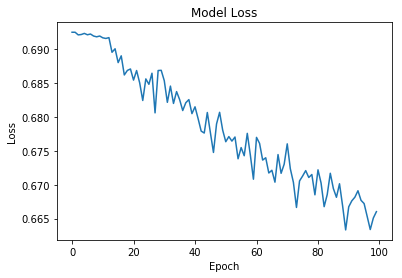

In [8]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
    
plot_loss(lstm_history)

In [9]:
# Evaluate model and predict data
scores = lstm_model.evaluate(x_test, y_test)
print("model: \n%s: %.2f%%" % (lstm_model.metrics_names[1], scores[1]*100))

y_predict = lstm_model.predict_classes(x_test)
cm = confusion_matrix(y_test, y_predict)
print(cm)

fpr_BDmodel, tpr_BDmodel, thresholds_BDmodel = roc_curve(y_test, y_predict)
auc_BDmodel = auc(fpr_BDmodel, tpr_BDmodel)
print(auc_BDmodel)

400/400 [==============================] - 0s 954us/step
model: 
acc: 62.00%
[[152  70]
 [ 82  96]]
0.612005263690657
